# LIBRERÍAS

In [1]:
!pip install xgboost==1.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pickle

import ETL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import utils
from keras.layers import Dense
from keras.models import Sequential
from sklearn import datasets, decomposition
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_curve,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_validate,
                                     train_test_split)
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor

2022-09-17 03:27:26.854445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 03:27:26.977680: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-17 03:27:26.982656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-17 03:27:26.982678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# DATA

In [3]:
df = ETL.etl(extract_path = "/work/data/train.csv")
df
kaggle = ETL.etl(extract_path = "/work/data/test.csv", kaggle=True)
kaggle

,PassengerId,Pclass,Sex,Age,Embarked,Title
0,892,3,0,34.5,1,1
1,893,3,1,47.0,2,1
2,894,2,0,62.0,1,1
3,895,3,0,27.0,2,1
4,896,3,1,22.0,2,1
...,...,...,...,...,...,...
408,1300,3,1,24.0,1,1
410,1302,3,1,24.0,1,1
413,1305,3,0,27.0,2,1
416,1308,3,0,27.0,2,1


# DATA SPLITTING

In [4]:
from sklearn.preprocessing import PowerTransformer

# TRAINING ..................................
X = df.drop(columns="Survived")
X_cols = X.columns
#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X = power.fit_transform(X)
#X = pd.DataFrame(X, columns = X_cols) 

scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)
y =  df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df.Survived, random_state=0)

# KAGGLE  ..................................
X_kaggle = kaggle
X_kaggle_cols = X_kaggle.columns
#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X_kaggle = power.fit_transform(X_kaggle)
#X_kaggle = pd.DataFrame(X_kaggle, columns = X_kaggle_cols) 
scaler = StandardScaler().fit(X_kaggle)
X_kaggle = pd.DataFrame(scaler.transform(X_kaggle), columns = X_kaggle.columns)

# VARIABLE IMPORTANCE

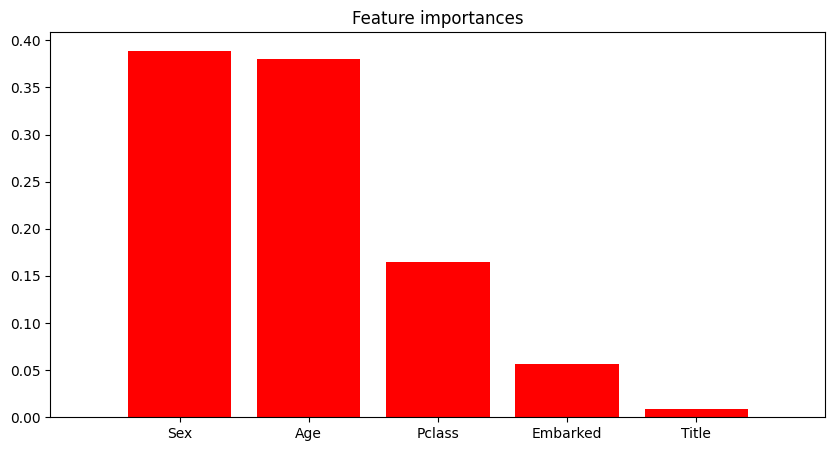

In [5]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X, y)

importances = sel.estimator_.feature_importances_
names = sel.estimator_.feature_names_in_

indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [names[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()

# SMART MODEL SELECTION 

In [6]:
models = [('KNN', KNeighborsClassifier()),
          ('SVC', SVC()),
          ('LR', LogisticRegression(max_iter=300000)),
          ('DT', DecisionTreeClassifier()),
          ('GNB', GaussianNB()),
          ('RF', RandomForestClassifier()),
          ('GB', GradientBoostingClassifier()),
          ('XGB', XGBClassifier())]

In [7]:
fitmodels_k = []
for name, model in models: 
    kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
    results = cross_validate(model, X, y, cv = kfold, scoring = ['accuracy', 'precision','recall','f1'])
    fitmodels_k.append( utils.MLmodel(name,
                              np.mean(results['test_accuracy']),
                              np.mean(results['test_precision']),
                              np.mean(results['test_recall']),
                              np.mean(results['test_f1'])))    
kval = pd.DataFrame.from_records([fitmodel.to_dict() for fitmodel in fitmodels_k])
kval

,name,accuracy,precision,recall,f1
0,KNN,0.755318,0.680909,0.674088,0.674122
1,SVC,0.817104,0.878608,0.601900,0.709133
2,LR,0.787878,0.725573,0.712892,0.716695
3,DT,0.797953,0.772056,0.666892,0.710996
4,GNB,0.774432,0.696858,0.724332,0.707371
5,RF,0.790087,0.739649,0.697015,0.712464
6,GB,0.811461,0.803848,0.653835,0.718834
7,XGB,0.808065,0.775935,0.690055,0.727003


## Neural Network 
**(Just a Test)**
Not stored/used in the ensembled model

2022-09-17 03:27:34.438444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-17 03:27:34.438492: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 03:27:34.438515: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-34b6ad67-9899-4609-8c36-e96f39426d07): /proc/driver/nvidia/version does not exist
2022-09-17 03:27:34.438838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Inicia el entrenamiento
Termina el entrenamiento

 Train
21/21 [

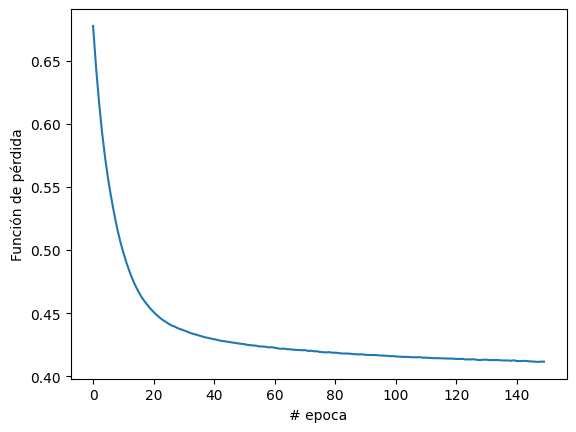

In [8]:
modelo_nn=Sequential()

modelo_nn.add(Dense(units=14,activation="linear",input_dim=X.to_numpy().shape[1]))
modelo_nn.add(Dense(units=18,activation="relu"))
modelo_nn.add(Dense(units=12,activation="relu"))
modelo_nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

modelo_nn.compile(
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()]
)

print("Inicia el entrenamiento")
historia  = modelo_nn.fit(X_train,y_train,epochs=150,verbose=False)
print("Termina el entrenamiento")

print("\n Train")
y_predicted = modelo_nn.predict(X_train)
y_predicted = np.argmax(y_predicted, axis=1)
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted = modelo_nn.predict(X_test)
y_predicted = np.argmax(y_predicted, axis=1)
print(classification_report(y_test,y_predicted))

plt.xlabel("# epoca")
plt.ylabel("Función de pérdida")
plt.plot(historia.history["loss"])

# MODEL DEEP DIVE

## RANDOM FOREST CLASSIFIER

In [9]:
rf_model = RandomForestClassifier()

# Full Data
print("Full Data")
rf_model.fit(X, y)
print(rf_model.get_params())
y_pred = rf_model.predict(X)
print(classification_report(y, y_pred))

# Partial Data
rf_model.fit(X_train, y_train)
print(rf_model.get_params())

print("Train")
y_pred = rf_model.predict(X_train)
print(classification_report(y_train, y_pred))
print("Test")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

Full Data
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       549
           1       0.91      0.83      0.87       342

    accuracy                           0.90       891
   macro avg       0.90      0.89      0.89       891
weighted avg       0.90      0.90      0.90       891

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_lea

### Parameters Search

In [ ]:
pca = decomposition.PCA()
rf_model = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('rf', rf_model)])
n_components = list(range(1,X.shape[1]+1,1))

params= {
    'pca__n_components' : n_components,
    'rf__criterion' : ['entropy','gini'],
    'rf__max_depth' : list(range(1,15,1))+[None],
    'rf__max_features': list(range(1,15,1))+["sqrt"],
    'rf__min_samples_leaf' : range(1,15,10),
    'rf__min_samples_split' : list(range(1,15,10)) + np.arange(0.1, 0.9, 0.1).tolist(),
    'rf__n_estimators' : range(0,1000,50),
    'rf__bootstrap'     : [True,False]
}

kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        pipe, params,
        cv = kfold,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_train,y_train)
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    pipe =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

Tuning for recall


### Model Evaluation

In [ ]:
params = {
    'criterion':'gini', 
    'n_estimators': 700,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features':'sqrt',
    'random_state':0,
    'max_depth':15,
}

rf_model = RandomForestClassifier(**params)
rf_model.fit(X_train, y_train)

print("\n Train")
y_predicted=rf_model.predict(X_train)
print("score: " ,rf_model.score(X_train,y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted=rf_model.predict(X_test)
print("score : " ,rf_model.score(X_test,y_test))
print(classification_report(y_test,y_predicted))


 Train
score:  0.8727544910179641
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       412
           1       0.89      0.77      0.82       256

    accuracy                           0.87       668
   macro avg       0.88      0.85      0.86       668
weighted avg       0.87      0.87      0.87       668


 Test
score :  0.8340807174887892
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       137
           1       0.89      0.65      0.75        86

    accuracy                           0.83       223
   macro avg       0.85      0.80      0.81       223
weighted avg       0.84      0.83      0.83       223



### Kaggle

In [ ]:
predictions = rf_model.predict(X_kaggle.drop("PassengerId", axis=1))
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions RF.csv'

submission.to_csv(filename,index=False)

### Storing rf model

In [ ]:
with open('survival_models/RF', 'wb') as files:
    pickle.dump(rf_model, files)

## LOGISTIC REGRESSION

In [ ]:
lr_model = LogisticRegression()

# Full Data
print("Full Data")
lr_model.fit(X, y)
print(lr_model.get_params())
y_pred = lr_model.predict(X)
print(classification_report(y, y_pred))

# Partial Data
lr_model.fit(X_train, y_train)
print(lr_model.get_params())

print("Train")
y_pred = lr_model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = lr_model.predict(X_test)
print("Test")
print(classification_report(y_test, y_pred))


Full Data
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       549
           1       0.73      0.71      0.72       342

    accuracy                           0.79       891
   macro avg       0.78      0.78      0.78       891
weighted avg       0.79      0.79      0.79       891

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Train
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     

In [ ]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_accuracy(self, X, y):
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
            
            accuracies = []
            tns = []
            fps = []
            fns = []
            tps = []

            for threshold in thresholds:
                y_pred_with_threshold = (y_scores >= threshold).astype(int)
                tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()

                accuracies.append((tp+tn)/(tn+fp+fn+tp))
                tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)
            
            df_accuracy = pd.DataFrame({'threshold':thresholds, 'accuracy':accuracies, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})

            max_accuracy = df_accuracy['accuracy'].max()
            threshold = df_accuracy[df_accuracy['accuracy']==max_accuracy].iloc[0]['threshold']

            return threshold, max_accuracy, df_accuracy

pca = decomposition.PCA()
logreg = LogisticRegression()

pipe = Pipeline(steps=[('pca', pca), ('logistic_Reg', logreg)])
n_components = list(range(1,X.shape[1]+1,1))
C = np.logspace(-3, 3, 50)
penalty = ['l1', 'l2']
solver = ['lbfgs', 'liblinear','newton-cg']

parameters = dict(pca__n_components=n_components,
                  logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty,
                  logistic_Reg__solver=solver
                  )

kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
logreg = GridSearchCV(pipe, parameters, cv=kfold)
logreg = LogisticRegressionWithThreshold()
logreg.fit(X_train, y_train)

threshold, max_accuracy, df_accuracy = logreg.threshold_from_optimal_accuracy(X_train, y_train)

print("\n Train")
y_predicted=logreg.predict(X_train, threshold)
print("score: ", logreg.score(X_train, y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted=logreg.predict(X_test, threshold)
print("score : ",logreg.score(X_test,y_test))
print(classification_report(y_test,y_predicted))


 Train
score:  0.7844311377245509
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       412
           1       0.82      0.63      0.72       256

    accuracy                           0.81       668
   macro avg       0.81      0.77      0.78       668
weighted avg       0.81      0.81      0.80       668


 Test
score :  0.8116591928251121
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       137
           1       0.94      0.58      0.72        86

    accuracy                           0.83       223
   macro avg       0.87      0.78      0.80       223
weighted avg       0.85      0.83      0.81       223



### Kaggle

In [ ]:
predictions = logreg.predict(X_kaggle.drop("PassengerId", axis=1), threshold)
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions LR.csv'

submission.to_csv(filename,index=False)

### Storing lr model

In [ ]:
with open('survival_models/lr', 'wb') as files:
    pickle.dump(logreg, files)

## DECISION TREE

In [ ]:
dt_model = DecisionTreeClassifier()

# Full Data
print("Full Data")
dt_model.fit(X, y)
print(dt_model.get_params())
y_pred = dt_model.predict(X)
print(classification_report(y, y_pred))

# Partial Data
dt_model.fit(X_train, y_train)
print(dt_model.get_params())

print("Train")
y_pred = dt_model.predict(X_train)
print(classification_report(y_train, y_pred))
print("Test")
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))


Full Data
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       549
           1       0.94      0.79      0.86       342

    accuracy                           0.90       891
   macro avg       0.91      0.88      0.89       891
weighted avg       0.91      0.90      0.90       891

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Train
              precision    recall  f1-score   support

           0       0.88      0.98      0.93 

Improving the model

In [ ]:
pca = decomposition.PCA()
dt_model = DecisionTreeClassifier()
pipe = Pipeline(steps=[('pca', pca), ('dt', dt_model)])
n_components = list(range(1,X.shape[1]+1,1))

params = {'pca__n_components' : n_components,
          'dt__max_depth': list(range(1,10))+[None], 
          'dt__min_samples_leaf' : range(1,10),
          'dt__min_samples_split': [1, 2, 3] + np.arange(0.1, 0.9, 0.1).tolist(),
          'dt__criterion' : ['gini', 'entropy'],
          'dt__max_features' : list(range(1,10,1))+[None]
        }
kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        pipe, params,
        cv = kfold,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_train,y_train)
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    pipe =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

Best model

In [ ]:
best_model = DecisionTreeClassifier(criterion="gini", max_depth=8, max_features=4, min_samples_leaf = 8, min_samples_split = 2)
best_model = best_model.fit(X_train,y_train)

print("\n Train")
y_predicted = best_model.predict(X_train)
print("score: ", best_model.score(X_train, y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted = best_model.predict(X_test)
print("score : ",best_model.score(X_test,y_test))
print(classification_report(y_test,y_predicted))


 Train
score:  0.8338323353293413
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       412
           1       0.84      0.70      0.76       256

    accuracy                           0.83       668
   macro avg       0.84      0.81      0.82       668
weighted avg       0.83      0.83      0.83       668


 Test
score :  0.852017937219731
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       137
           1       0.91      0.69      0.78        86

    accuracy                           0.85       223
   macro avg       0.87      0.82      0.83       223
weighted avg       0.86      0.85      0.85       223



In [ ]:
predictions = best_model.predict(X_kaggle.drop("PassengerId", axis=1))
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions DT.csv'

submission.to_csv(filename,index=False)

### Storing DT Model


In [ ]:
with open('survival_models/dt', 'wb') as files:
    pickle.dump(best_model, files)

## GRADIENT BOOST

In [ ]:
gb_model = GradientBoostingClassifier()

# Full Data
print("Full Data")
gb_model.fit(X, y)
print(gb_model.get_params())
y_pred = gb_model.predict(X)
print(classification_report(y, y_pred))

# Partial Data
gb_model.fit(X_train, y_train)
print(gb_model.get_params())

print("Train")
y_pred = gb_model.predict(X_train)
print(classification_report(y_train, y_pred))
print("Test")
y_pred = gb_model.predict(X_test)
print(classification_report(y_test, y_pred))


Full Data
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       549
           1       0.89      0.72      0.79       342

    accuracy                           0.86       891
   macro avg       0.87      0.83      0.84       891
weighted avg       0.86      0.86      0.85       891

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'mi

### Parameter Evaluation

In [ ]:
pca = decomposition.PCA()
gb_model = GradientBoostingClassifier()
pipe = Pipeline(steps=[('pca', pca), ('gb', gb_model)])
n_components = list(range(1,X.shape[1]+1,1))

params = {
    'pca__n_components' : n_components,
    "gb__n_estimators":[5,50,250,500],        
    "gb__max_depth":[1,3,5,7, 9]+[None],              
    "gb__learning_rate":[0.01, 0.001,0.1,1,10, 100],   
    "gb__max_features": [1, 10, 11, 50]+[None]                
}

kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        pipe, params,
        cv = kfold,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_train,y_train)
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    pipe =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

Tuning for recall


KeyboardInterrupt: 

### Best Model

In [ ]:
params = {'learning_rate': 1, 'max_depth': 1, 'max_features': 10, 'n_estimators': 50}

model = GradientBoostingClassifier(**params)
model = model.fit(X_train,y_train)

print("\n Train")
y_predicted = model.predict(X_train)
print("score: ", model.score(X_train, y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted = model.predict(X_test)
print("score : ", model.score(X_test,y_test))
print(classification_report(y_test,y_predicted))


 Train
score:  0.8248502994011976
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       412
           1       0.79      0.74      0.76       256

    accuracy                           0.82       668
   macro avg       0.82      0.81      0.81       668
weighted avg       0.82      0.82      0.82       668


 Test
score :  0.8385650224215246
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       137
           1       0.85      0.71      0.77        86

    accuracy                           0.84       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.84      0.84      0.84       223



### Kaggle

In [ ]:
predictions = model.predict(X_kaggle.drop("PassengerId", axis=1))
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions GB.csv'
submission.to_csv(filename,index=False)

### Storing GB Model

In [ ]:
with open('survival_models/gb', 'wb') as files:
    pickle.dump(model, files)

## XGBOOST

In [ ]:
xgb_model = XGBClassifier()

# Full Data
print("Full Data")
xgb_model.fit(X, y)
print(xgb_model.get_params())
y_pred = xgb_model.predict(X)
print(classification_report(y, y_pred))

# Partial Data
gb_model.fit(X_train, y_train)
print(xgb_model.get_params())

print("Train")
y_pred = xgb_model.predict(X_train)
print(classification_report(y_train, y_pred))
print("Test")
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


Full Data
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
              precision    recall  f1-score   support

           0       0.88      0.96      0.91       549
           1       0.92      0.78     

### Improving the model 

In [ ]:
pca = decomposition.PCA()
xgb_model = XGBClassifier()
pipe = Pipeline(steps=[('pca', pca), ('xgb', xgb_model)])
n_components = list(range(1,X.shape[1]+1,1))
#model = 
params = {   'pca__n_components' : n_components,
              'xgb__n_estimators': [5,25,50,100,200,400,1000],
             'xgb__max_depth': [1,2,3,4,5,6,7,8]+[None], 
             'xgb__min_child_weight': [1,2,3,4],
             'xgb__learning_rate': [.2, .3, .4, 1],
             'xgb__colsample_bytree': [.7, .8, .9, 1],
             'xgb__objective': ['binary:logistic']}
kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        pipe, params,
        cv = kfold,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_train,y_train)
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    pipe =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

In [ ]:
params = {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 5, 'objective': 'binary:logistic'}

model = XGBClassifier(**params)
model = model.fit(X_train,y_train)

print("\n Train")
y_predicted = model.predict(X_train)
print("score: ", model.score(X_train, y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted = model.predict(X_test)
print("score : ", model.score(X_test,y_test))
print(classification_report(y_test,y_predicted))


 Train
score:  0.8308383233532934
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       412
           1       0.84      0.69      0.76       256

    accuracy                           0.83       668
   macro avg       0.83      0.80      0.81       668
weighted avg       0.83      0.83      0.83       668


 Test
score :  0.8340807174887892
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       137
           1       0.89      0.65      0.75        86

    accuracy                           0.83       223
   macro avg       0.85      0.80      0.81       223
weighted avg       0.84      0.83      0.83       223



### Kaggle

In [ ]:
predictions = model.predict(X_kaggle.drop("PassengerId", axis=1))
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions XGB.csv'
submission.to_csv(filename,index=False)

### Storing XGB model

In [ ]:
with open('survival_models/xgb', 'wb') as files:
    pickle.dump(model, files)

# ENSAMBLE

In [ ]:
import os
route = 'survival_models/'
directory = os.fsencode(route)

estimators = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with open((route+filename).replace(" ",""), 'rb') as f:
        model = pickle.load(f)
        if (filename not in ["nn", "ensemble", "lr"]):
            estimators.append((model.__class__.__name__, model))

from sklearn.ensemble import VotingClassifier

print([ estimator[0]  for estimator in estimators])
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,1,1,1])
ensemble.fit(X_train, y_train)


print("\n Train")
y_predicted = model.predict(X_train)
print("score: ", model.score(X_train, y_train))
print(classification_report(y_train,y_predicted))

print("\n Test")
y_predicted = model.predict(X_test)
print("score : ", model.score(X_test,y_test))
print(classification_report(y_test,y_predicted))

['XGBClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       137
           1       0.95      0.71      0.81        86

    accuracy                           0.87       223
   macro avg       0.90      0.84      0.86       223
weighted avg       0.89      0.87      0.87       223



### Kaggle

In [ ]:
predictions = ensemble.predict(X_kaggle.drop("PassengerId", axis=1))
submission = pd.DataFrame({'PassengerId':kaggle['PassengerId'],'Survived':predictions})

filename = 'submits/Titanic Predictions ensemble_noLr.csv'
submission.to_csv(filename,index=False)

### Storing ensemble model

In [ ]:
with open('survival_models/ensemble_nolr', 'wb') as files:
    pickle.dump(model, files)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=34b6ad67-9899-4609-8c36-e96f39426d07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>